In [1]:
import pandas as pd

In [4]:
df = pd.read_csv('/root/QuantAndCo/Data/Backtest/Optimization/Pairs_trading_EUR_USD_optimization_20222024_3.csv')

In [5]:
df

,Combination #,start_date,end_date,window,long_thres,short_thres,leverage,performance
0,1,2023-10-09,2023-11-28,1000,-2.0,0.5,1,0.021853
1,1,2023-04-25,2023-06-14,1000,-2.0,0.5,1,0.012568
2,1,2020-12-15,2021-02-07,1000,-2.0,0.5,1,0.022476
3,1,2020-06-03,2020-07-24,1000,-2.0,0.5,1,-0.002547
4,1,2023-09-21,2023-11-10,1000,-2.0,0.5,1,0.041155
...,...,...,...,...,...,...,...,...
6395,64,2022-06-09,2022-07-28,50000,-0.5,2.0,1,0.008307
6396,64,2023-03-19,2023-05-08,50000,-0.5,2.0,1,0.009083
6397,64,2021-09-17,2021-11-12,50000,-0.5,2.0,1,-0.001096
6398,64,2023-01-04,2023-02-22,50000,-0.5,2.0,1,0.000775


In [6]:
df.window.unique()

array([ 1000,  5000, 10000, 50000])

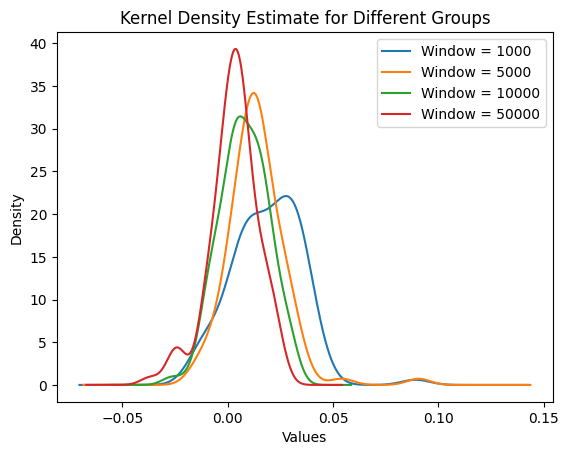

In [8]:
import matplotlib.pyplot as plt

long = -1.5
short = 1.5
for window in df.window.unique():
    try:
        subset = df[(df['long_thres'] == long) & (df['short_thres'] == short) & (df['window'] == window)]  # Filter data for each group
        subset['performance'].plot.kde(label=f'Window = {window}')
    except:
        continue

plt.title('Kernel Density Estimate for Different Groups')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.show()

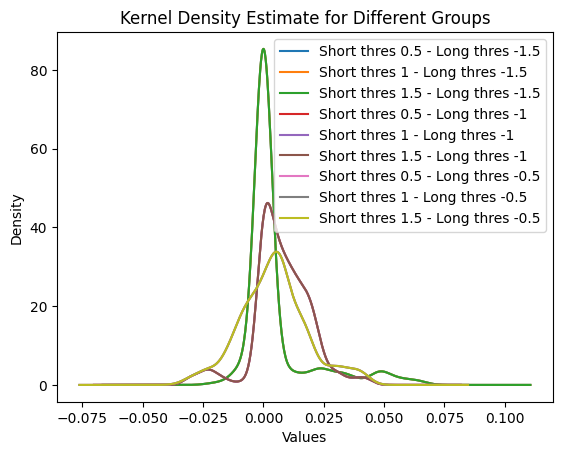

In [5]:
import matplotlib.pyplot as plt

# List unique groups
long_ = [-1.5, -1, -0.5]
short_ = [0.5, 1, 1.5]

# Plotting KDE for each group
for long in long_:
    for short in short_:
        try:
            subset = df[(df['long_thres'] == long) & (df['short_thres'] == short)]  # Filter data for each group
            subset['performance'].plot.kde(label=f'Short thres {short} - Long thres {long}')
        except:
            print(f'No KDE for {short} and {long}')
            continue

plt.title('Kernel Density Estimate for Different Groups')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.show()

In [4]:
df.sort_values(by='performance', ascending=False)

#perf
#dd
#temps avant d'atteindre le drawdown

,Combination #,start_date,end_date,long_thres,short_thres,leverage,performance,loss
1782,17,2022-08-24,2022-10-12,-1.503249,0.974934,1,0.065774,-0.065774
9082,90,2022-08-24,2022-10-12,-1.468462,1.030341,1,0.065721,-0.065721
5482,54,2022-08-24,2022-10-12,-1.494258,2.367196,1,0.064802,-0.064802
682,6,2022-08-24,2022-10-12,-1.466285,2.461851,1,0.064111,-0.064111
8682,86,2022-08-24,2022-10-12,-1.545287,1.426522,1,0.063014,-0.063014
...,...,...,...,...,...,...,...,...
8069,80,2022-06-06,2022-07-25,-0.846063,1.783001,1,-0.026058,0.026058
3469,34,2022-06-06,2022-07-25,-0.396860,0.299921,1,-0.026058,0.026058
9969,99,2022-06-06,2022-07-25,-0.280739,1.675043,1,-0.026058,0.026058
3669,36,2022-06-06,2022-07-25,-0.787772,0.543271,1,-0.026058,0.026058


In [1]:
import numpy as np

def calculate_tick_rule(price_change):
    """
    Implements the tick rule to classify a trade as a buy (+1) or sell (-1)
    based on the price change.
    """
    if price_change == 0:
        return np.sign(price_change)
    else:
        return np.sign(price_change)

def compute_tib(prices, volumes, exp_weighted_span=30):
    """
    Computes Tick Imbalance Bars (TIBs) for a given sequence of prices and volumes.
    
    Args:
        prices (list or np.array): A sequence of trade prices.
        volumes (list or np.array): A sequence of trade volumes corresponding to the prices.
        exp_weighted_span (int): The span for computing exponentially weighted moving averages.
        
    Returns:
        list: A list of tuples, where each tuple contains the start and end indices of a TIB.
    """
    
    # Calculate price changes and apply the tick rule
    price_changes = np.diff(prices)
    tick_rules = [calculate_tick_rule(pc) for pc in price_changes]
    tick_rules.insert(0, tick_rules[-1])  # Set boundary condition for b0
    
    # Compute the tick imbalance at each step
    tick_imbalance = np.cumsum(tick_rules)
    
    # Estimate the expected size of the tick bar and the probability of a buy
    exp_T = np.exp_mov_avg(tick_imbalance, span=exp_weighted_span)
    prob_buy = np.exp_mov_avg(np.array(tick_rules) == 1, span=exp_weighted_span)
    
    # Compute the expected tick imbalance
    exp_tick_imbalance = exp_T * (2 * prob_buy - 1)
    
    # Find the indices where the tick imbalance exceeds the expected threshold
    imbalance_threshold = np.abs(2 * prob_buy - 1)
    exceeding_indices = np.flatnonzero(np.abs(tick_imbalance) >= exp_tick_imbalance * imbalance_threshold)
    
    # Construct the TIBs
    tibs = []
    start_idx = 0
    for end_idx in exceeding_indices:
        tibs.append((start_idx, end_idx))
        start_idx = end_idx
    
    return tibs

In [2]:
prices = [10, 11, 12, 11, 10, 9, 10, 11]
volumes = [100, 200, 300, 150, 100, 200, 150, 250]
tibs = compute_tib(prices, volumes)
print(tibs)

AttributeError: module 'numpy' has no attribute 'exp_mov_avg'

In [3]:
import numpy as np
import pandas as pd

def calculate_tick_rule(price_change):
    """
    Implements the tick rule to classify a trade as a buy (+1) or sell (-1)
    based on the price change.
    """
    if price_change == 0:
        return np.sign(price_change)
    else:
        return np.sign(price_change)

def compute_tib(prices, volumes, exp_weighted_span=30):
    """
    Computes Tick Imbalance Bars (TIBs) for a given sequence of prices and volumes.
    
    Args:
        prices (list or np.array): A sequence of trade prices.
        volumes (list or np.array): A sequence of trade volumes corresponding to the prices.
        exp_weighted_span (int): The span for computing exponentially weighted moving averages.
        
    Returns:
        list: A list of tuples, where each tuple contains the start and end indices of a TIB.
    """
    
    # Calculate price changes and apply the tick rule
    price_changes = np.diff(prices)
    tick_rules = [calculate_tick_rule(pc) for pc in price_changes]
    tick_rules.insert(0, tick_rules[-1])  # Set boundary condition for b0
    
    # Convert to pandas Series for convenience
    tick_rules_series = pd.Series(tick_rules)
    
    # Compute the tick imbalance at each step
    tick_imbalance = tick_rules_series.cumsum()
    
    # Estimate the expected size of the tick bar and the probability of a buy
    exp_T = tick_imbalance.ewm(span=exp_weighted_span).mean()
    prob_buy = (tick_rules_series == 1).ewm(span=exp_weighted_span).mean()
    
    # Compute the expected tick imbalance
    exp_tick_imbalance = exp_T * (2 * prob_buy - 1)
    
    # Find the indices where the tick imbalance exceeds the expected threshold
    imbalance_threshold = np.abs(2 * prob_buy - 1)
    exceeding_indices = tick_imbalance.index[np.abs(tick_imbalance) >= exp_tick_imbalance * imbalance_threshold]
    
    # Construct the TIBs
    tibs = []
    start_idx = 0
    for end_idx in exceeding_indices:
        tibs.append((start_idx, end_idx))
        start_idx = end_idx
    
    return tibs

In [4]:
prices = [10, 11, 12, 11, 10, 9, 10, 11]
volumes = [100, 200, 300, 150, 100, 200, 150, 250]
tibs = compute_tib(prices, volumes)
print(tibs)

[(0, 0), (0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7)]


In [ ]:
volumes